Tom Barclay's xoflares on EPIC-246301900

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

In [4]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.3.3
1.0.5
3.9.3
1.11.2


In [ ]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

In [4]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

(3379,)


In [7]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [78]:
fits.getheader(filename)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-02-28'         / file creation date.                            
CREATOR = '1003547 FluxExporter2PipelineModule' / pipeline job and program used 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.109 r63647' / SW version  
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [10]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [34]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))


3255


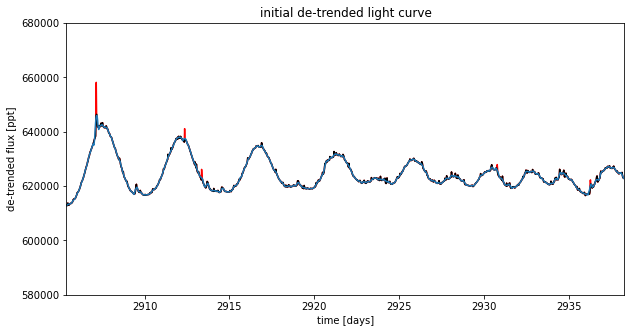

In [54]:
# get a smoothed version of the light curve
smooth = savgol_filter(pre.PDCSAP_FLUX, 13, polyorder=3)
resid = pre.PDCSAP_FLUX - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(pre.TIME, pre.PDCSAP_FLUX, "r")
plt.plot(pre.TIME[mask], pre.PDCSAP_FLUX[mask], "k")
plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(pre.TIME.min(), pre.TIME.max());

In [65]:
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(pre)

[-14.69051155  -9.48030758  -8.47913517   8.94926485  14.42495513] [12598.6875  3633.25    3143.5625  2096.75    2112.125 ] [0.00277778 0.00277778 0.00277778 0.00277778 0.00277778] 5


/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

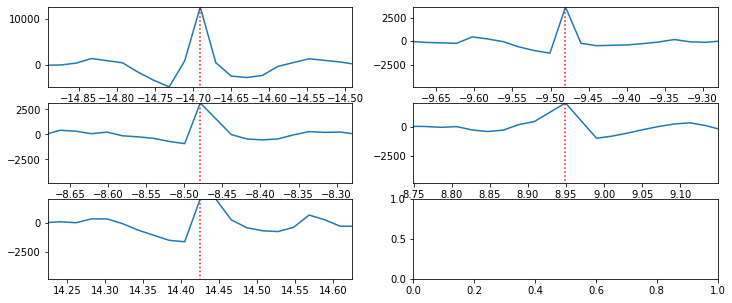

In [66]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

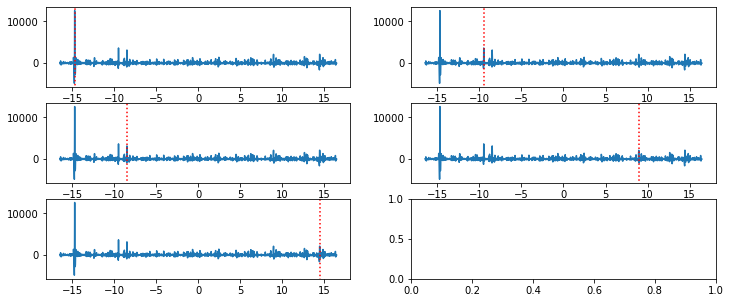

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    #ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))


In [69]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [70]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


message: Optimization terminated successfully.
logp: -39027.32069118855 -> -39027.32069118855
optimizing logp for variables: [mean, logAmpl]


message: Optimization terminated successfully.
logp: -39027.32069118855 -> -39027.32069118855
optimizing logp for variables: [logAmpl, logFwhm]


message: Optimization terminated successfully.
logp: -39027.32069118855 -> -39027.32069118855
optimizing logp for variables: [tpeak]


message: Optimization terminated successfully.
logp: -39027.32069118855 -> -39027.32069118855


Finished [100%]: Average Loss = 11,096


In [71]:
start[0]['tpeak'] - 0.2

array([-14.89075256,  -9.68050477,  -8.67859309,   8.7497648 ,
        14.22456477])

/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '

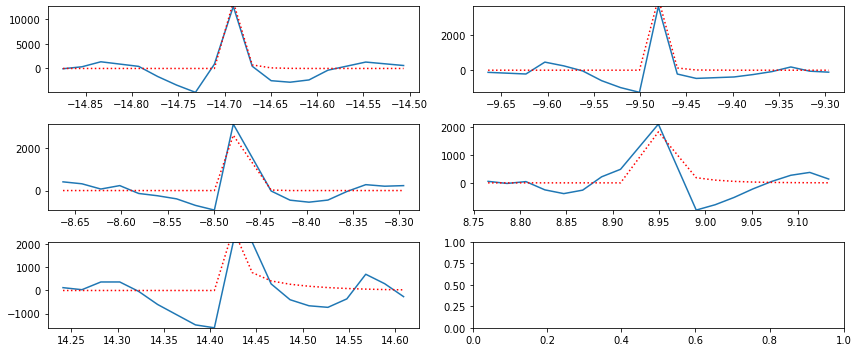

In [72]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [35]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [73]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 2898 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logAmpl__0,12.167456,0.103059,0.004305,11.956442,12.375783,512.968596,1.001773
logAmpl__1,8.588594,0.466535,0.013777,7.798850,9.513316,1002.485591,1.000054
logAmpl__2,9.098854,0.438011,0.017620,8.285205,10.012890,544.745071,1.003032
logAmpl__3,8.789599,0.477604,0.016532,8.025588,9.717521,713.488786,1.001355
logAmpl__4,9.088399,0.515193,0.023384,8.153142,10.025358,341.915815,1.005419
logAmpl__5,8.620816,0.503330,0.015988,7.804448,9.640853,777.634839,1.000157
logAmpl__6,9.630436,0.346921,0.014076,8.963813,10.282711,584.481243,1.001363
logFwhm__0,-5.592025,0.061982,0.002573,-5.719804,-5.463305,522.149935,1.001800
logFwhm__1,-5.681925,0.622183,0.016648,-6.989386,-4.566320,1488.868938,1.001650
logFwhm__2,-4.576157,0.362388,0.014531,-5.244593,-3.821656,539.100848,1.004636


/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '

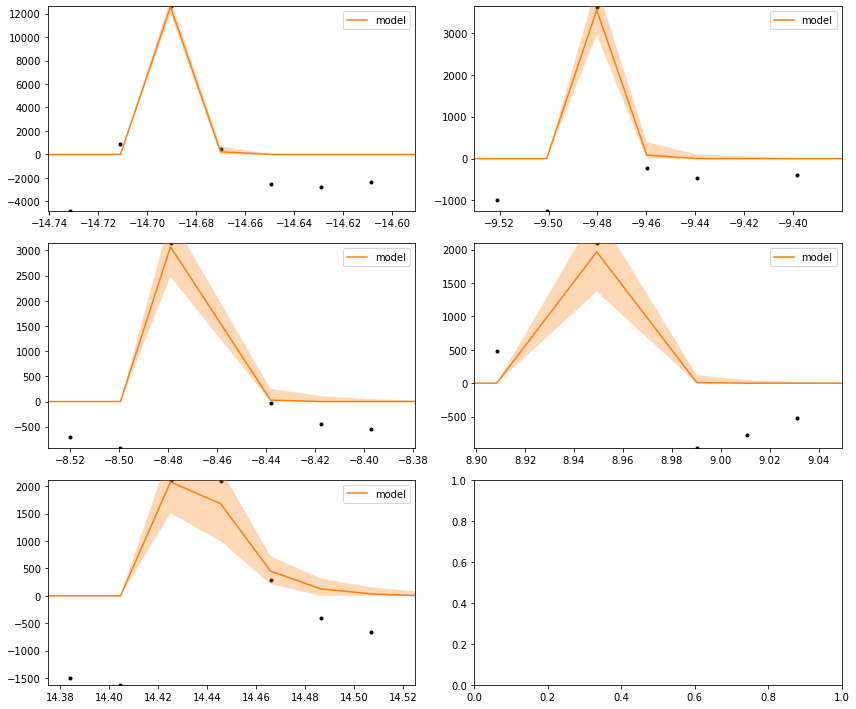

In [74]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()
    
fig.tight_layout()
#fig.savefig('flare-model.png')

In [75]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

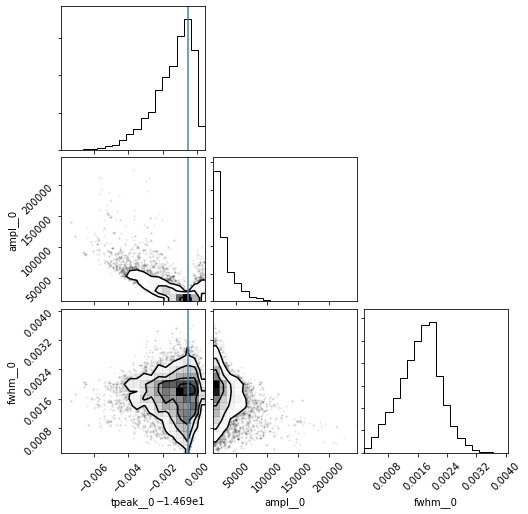

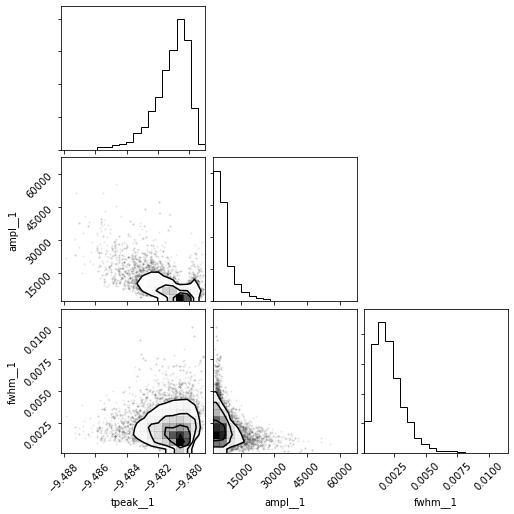

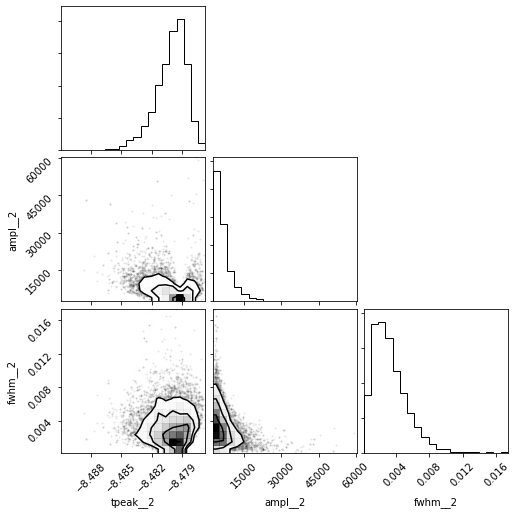

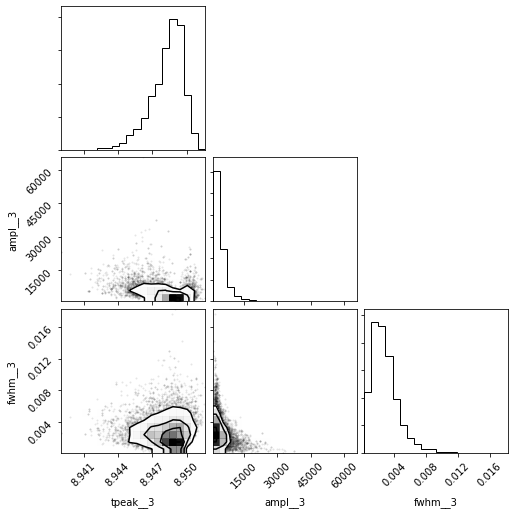

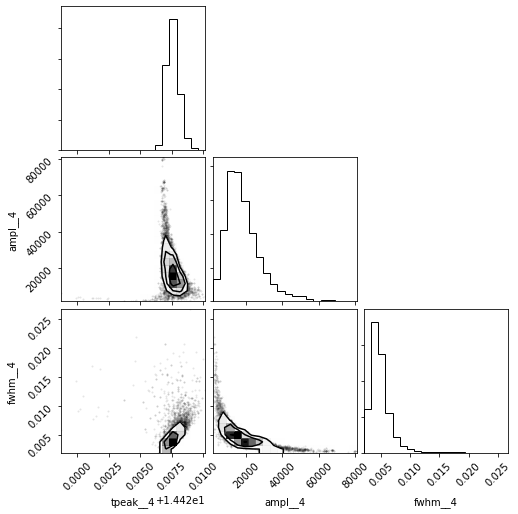

In [76]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

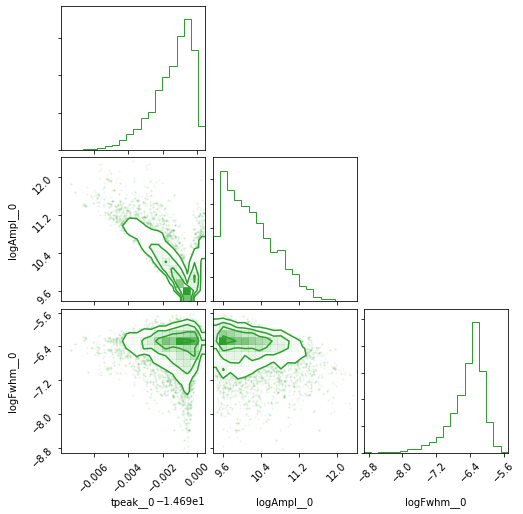

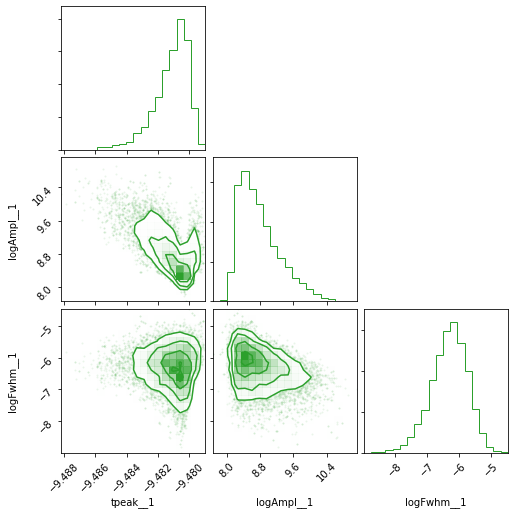

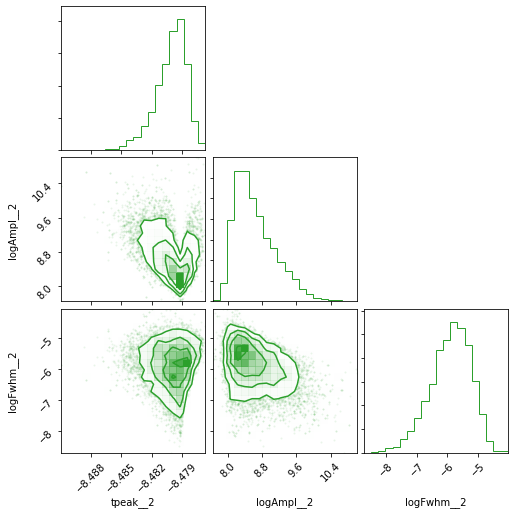

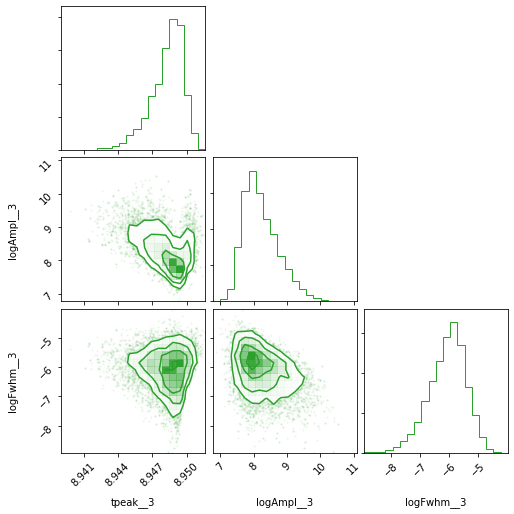

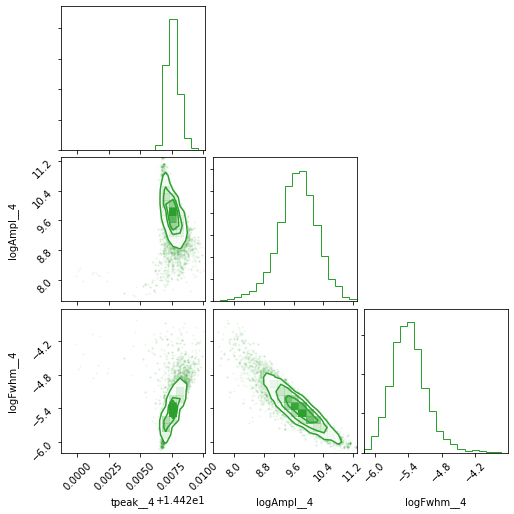

In [77]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

#### Measuring Flare Energy

From Doyle et al 2018 "Investigating the rotational phase of stellar flares on M dwarfs using K2 short cadence data"

"To determine the energy of the stellar flares, the quiescent luminosity of the star, L_star, must be calculated in the Kepler bandpass. To construct a template spectral energy distribution for each star we used PanStarrs magnitudes g, r, i, and z (see Table A1). The PanStarrs magnitudes (Chambers et al. 2016) represent the mean quiescent magnitude of the star calculated over an average of multiple measurements. This ensures the effects of flares or rotation has been removed from the magnitudes. We fitted a polynomial to the Panstarrs data and determined the flux in the Keplerbandpass in the same manner as Kowalski et al. (2013). The quiescent luminosity is then computed by multiplying the flux by 4πd2, where the distance (d) to the stars has been determined by inverting the parallax from the Gaia Data 2 release (Gaia Collaboration et al. 2016, 2018; see Table 3)...The energy of the flares, Eflare, can then be determined by the multiplication of the luminosity of the star, L*, in erg s−1 and the equivalent duration, t, in seconds. The equivalent duration (Gershberg 1972) is defined as the area under the flare light curve in units of seconds"

OR, from Davenport 2016 "THE KEPLER CATALOG OF STELLAR FLARES": <br>

"For this reason it
better to not assume a single flare spectrum, and instead
I estimate the distance and luminosity for each star to
determine it’s quiescent luminosity.
The Kepler Input Catalog provides ground-based photometry for all available stars in the Kepler field of view.
Using Version 10 of this catalog
, I obtained the g, Ks,
and Kp (Kepler) photometry for every star in the sample. The g − Ks color is then used to place each star
on to a stellar isochrone model, which gives an absolute
magnitude and mass for each star. Typical photometric
uncertainties from the g − Ks color propagate to mass
uncertainties of ∼0.02 M_star. This assumes that all stars
in the sample are on the isochrone’s main sequence. A 1-
Gyr isochrone from the PARSEC models (Bressan et al.
2012) with Z=0.019 and no dust extinction is used. Note
this will yield an incorrect distance for giant and subgiant stars. The star’s absolute g, Ks, and Kp (Kepler)
magnitudes are determined by linearly interpolating the
observed g − K color to the gridded values from the
isochrone. The apparent Ks magnitude for each star is
used to determine the distance modulus. The isochronederived absolute Kp magnitude is finally converted from
AB magnitudes to a quiescent luminosity, which is denoted LKp, and is used to convert flare ED’s to energies. The resulting flare energy that is calculated does
not correct for the spectrum of the flare through the
Kepler bandpass, or for the flare energy emitted outside
the Kepler bandpass, as discussed more in §6."

Get Kepler magnitude<br> (https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml; Smith et al (ApJ 123, 2121, 2002, Table 7)) <br><br>
Convert from AB magnitude to quiescent luminosity<br> (Davenport 2016; https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions; Oke, J.B. 1974, ApJS, 27, 21)

In [121]:
# flare energy = L_star * ed
# ed = area under the curve
# L_star = 4 * pi * d**2 * luminosity_q
# d = 1/parallax
# luminosity_q = average g, r, i, z magnitudes???
g = 12.076
r = 10.864
i = 10.228
parallax = 21.6345 # in milliarcsecs (mas)
distance = 1./(parallax*0.001) # parsecs
print(distance)

def calculate_energy():
    #l_star = (4*np.pi*distance**2) * ((g+r+i)/3)
    lkp = (4*np.pi*distance**2) * kepmag_zeropoint_luminosity(g, r) * 4000
    print("log LKp: ", np.log10(lkp))
    ed = 0.5*86400*0.05*12000 # from eyeballing one of the flare triangles above
    print("ED: ", ed)
    return np.log10(lkp*ed) # show order of energy in ergs...needs to be ~>27
 
def kepmag_zeropoint_luminosity(g, r): 
    ### kepmag
    # greater error for M dwarfs w/Teff < 3500 K
    # https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml
    if (g-r) <= 0.8:
        kp = 0.2*g + 0.8*r
    else:
        kp = 0.1*g + 0.9*r
    print("Kp: ", kp)
    
    ### zeropoint, bolometric correction, and magnitude-to-luminosity formula
    # AB mag to f, then multiply by Kepler filter FWHM of 4000 Angstroms
    # per https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    # and https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    
    #pre_lkp = 4000 * np.exp(-(kp+48.6)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    #pre_lkp = 4000 * np.exp(-(kp+4.81)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://academic.oup.com/mnras/article/433/2/1133/1747991
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(4.81-kp)) # Eqn 3 in https://academic.oup.com/mnras/article/433/2/1133/1747991
    pre_lkp = l_sun * np.power(10, 0.4*(-20.24-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    #f12 = 1.74e5 # e-/s, per https://keplergo.arc.nasa.gov/CalibrationSN.shtml
    #pre_lkp = f12 * np.power(10, 0.4*(12-kp))
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    return pre_lkp
    
print("log flare energy: ", calculate_energy())


46.22246874205551
Kp:  10.985200000000003
log pre LKp:  22.98889030267259
log LKp:  31.01986643288431
ED:  25920000.0
log flare energy:  38.43350143008286


#### Flare Frequency Distribution